# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.max_columns=200

from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [1]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.max_columns=200

from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs

from pmdarima.arima.utils import nsdiffs

In [2]:
# file path
read_data = "pollution_us_2000_2016.csv"

# read the dataset
df = pd.read_csv(read_data)

# drop the first column as it indicate just row numbers
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head(3)

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,2.975,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN


In [3]:
# check data shape 
df.shape

(1746661, 28)

In [4]:
# check for duplicates row in the dataset
df.duplicated().sum()

5032

In [5]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

# check new data shape
df.shape

(1741629, 28)

# Descriptive statisitics of numerical attribute helps in understanding data distribution. It displays the mean, standard deviation, and percentile for all the numerical column in the dataset.

1. For example from below table we can see the mean AQI for different pollutants.
2. Also we can the minimum and maximum value of AQI for all the pollutants.

3. This is just done to understand data well for example after this step I know that O3 AQI minimum value would be 0 and maximum value is 420 in the dataset.

4. This statistics is not at all related to training

In [6]:
# check descriptive statistics for numerical attribute
df.describe()

,State Code,County Code,Site Num,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
count,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,1.741629e+06,871285.000000,1.741629e+06,1.741629e+06,1.741629e+06,870641.000000
mean,2.227342e+01,7.161298e+01,1.120184e+03,1.282225e+01,2.541112e+01,1.172808e+01,2.389458e+01,2.611990e-02,3.919667e-02,1.016794e+01,3.603631e+01,1.872209e+00,4.496270e+00,9.663176e+00,7.121317,3.683295e-01,6.203171e-01,7.872603e+00,5.995909
std,1.724575e+01,7.954513e+01,2.004000e+03,9.509134e+00,1.599956e+01,7.876583e+00,1.516127e+01,1.136705e-02,1.533386e-02,4.002038e+00,1.974284e+01,2.762601e+00,7.685450e+00,6.729269e+00,11.942978,3.139755e-01,6.438836e-01,7.977721e+00,5.845416
min,1.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000,-4.375000e-01,-4.000000e-01,0.000000e+00,0.000000
25%,6.000000e+00,1.700000e+01,9.000000e+00,5.750000e+00,1.300000e+01,5.000000e+00,1.200000e+01,1.787500e-02,2.900000e-02,9.000000e+00,2.500000e+01,2.571430e-01,9.000000e-01,5.000000e+00,1.000000,1.833330e-01,2.920000e-01,0.000000e+00,2.000000
50%,1.700000e+01,5.900000e+01,6.000000e+01,1.073913e+01,2.400000e+01,9.000000e+00,2.300000e+01,2.587500e-02,3.800000e-02,1.000000e+01,3.300000e+01,9.875000e-01,2.000000e+00,8.000000e+00,3.000000,2.939130e-01,4.000000e-01,6.000000e+00,5.000000
75%,4.000000e+01,9.700000e+01,1.039000e+03,1.771429e+01,3.560000e+01,2.000000e+01,3.300000e+01,3.388900e-02,4.800000e-02,1.100000e+01,4.200000e+01,2.328571e+00,5.000000e+00,1.400000e+01,9.000000,4.666670e-01,8.000000e-01,1.300000e+01,8.000000
max,8.000000e+01,6.500000e+02,9.997000e+03,1.395417e+02,2.670000e+02,2.300000e+01,1.320000e+02,9.508300e-02,1.410000e-01,2.300000e+01,2.180000e+02,3.216250e+02,3.510000e+02,2.300000e+01,200.000000,7.508333e+00,1.990000e+01,2.300000e+01,201.000000


# Descriptive statisitics of categorical attribute helps in understanding data distribution.

1. It displays the nummber of unique values and most frequent value in all the categorical column in the dataset.

2. For example from below table we can see "Address" column has 204 unique values with most frequent value being "PIKE AVE AT RIVER ROAD".

3. This is done to understand data well for example after this step I know that NO2 & SO2 units are measured in Parts per billion across the dataset as there is only single value.

4. O3 & CO units are measured in Parts per million across the dataset as there is only single value.

5. This statistics is not at all related to training

I belived that this data is captured by AIR Quality Monitoring Station which are situated in different countries and different states and it may happen some countries/cities might not have any AIQ Quality station hence there is not data for them. 

In [7]:
# check descriptive statistics for categorical attribute
df.describe(include=np.object)

,Address,State,County,City,Date Local,NO2 Units,O3 Units,SO2 Units,CO Units
count,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629
unique,204,47,133,144,5996,1,1,1,1
top,PIKE AVE AT RIVER ROAD,California,Los Angeles,Not in a city,2013-04-17,Parts per billion,Parts per million,Parts per billion,Parts per million
freq,35117,575628,93371,138375,408,1741629,1741629,1741629,1741629


In [8]:
# check for unique state in the data
df['State'].nunique()

47

In [9]:
# check for unique country in the data
df['County'].nunique()

133

In [10]:
# check for unique City in the data
df['City'].nunique()

144

# The below code displays the count of missing data points for each column in the dataset

0 indicates that this column does not have any missing value.

# When loading csv files, the date column in the dataset is read as text data by python pandas.

To work with Time Series we need to convert this text date into python date time so that python knows this column refers to calender date and time otherwise it would be just some text for python

After converting it to python date time we are checking descriptive statistics which revelas the range of the calender date time for example the below code shows that we have date from 2000-01-01 to 2016-05-31

In [11]:
# check for missing value 
df.isna().sum()

State Code                0
County Code               0
Site Num                  0
Address                   0
State                     0
County                    0
City                      0
Date Local                0
NO2 Units                 0
NO2 Mean                  0
NO2 1st Max Value         0
NO2 1st Max Hour          0
NO2 AQI                   0
O3 Units                  0
O3 Mean                   0
O3 1st Max Value          0
O3 1st Max Hour           0
O3 AQI                    0
SO2 Units                 0
SO2 Mean                  0
SO2 1st Max Value         0
SO2 1st Max Hour          0
SO2 AQI              870344
CO Units                  0
CO Mean                   0
CO 1st Max Value          0
CO 1st Max Hour           0
CO AQI               870988
dtype: int64

In [12]:
# convert Date local to python date and time 
df['date'] =  pd.to_datetime(df['Date Local'])

# check descriptive statistics for date
df['date'].describe(datetime_is_numeric=True)

count                          1741629
mean     2008-10-12 22:57:38.410488320
min                2000-01-01 00:00:00
25%                2004-11-20 00:00:00
50%                2009-01-31 00:00:00
75%                2012-11-07 00:00:00
max                2016-05-31 00:00:00
Name: date, dtype: object

# Time Series data needs to have only value for each date and here we have multiple value of AQI for same city for a single date.

To create Time Series data we are aggregating data by calculating MEAN AQI for each day for each city. This would ensure for given city we have only value AQI for any given date.

Since we are interested in AQI prediction we are aggreating the dataset only for AQI's columns. 

In [13]:
# compute mean AQI for each citiy for each date
mean_aqi = df.groupby(['City','date'])[['NO2 AQI','O3 AQI','SO2 AQI','CO AQI']].mean()

# check new data frame
mean_aqi.head(3)

NO2 AQI  O3 AQI  SO2 AQI  CO AQI
City        date                                        
Albuquerque 2011-01-01     19.0    30.0      0.0     2.0
            2011-01-02     38.0    28.0      1.0     7.0
            2011-01-03     44.0    14.0      3.0    13.0

In [14]:
# check data shape
mean_aqi.shape

(359263, 4)

# This is again checking AQI distribution like what is minimum value and maximum value

In [15]:
# check descriptive statistics
mean_aqi.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
count,359263.000000,359263.000000,359263.000000,359089.000000
mean,24.235140,36.149585,7.512030,6.100780
std,14.913906,19.902530,12.302273,5.957218
min,0.000000,0.000000,0.000000,0.000000
25%,13.000000,25.000000,1.000000,2.000000
50%,23.000000,33.000000,3.000000,5.000000
75%,33.500000,42.000000,9.000000,8.000000
max,132.000000,218.000000,200.000000,201.000000


# Checking missing data in the dataset as these are the values which we need to forecast.

If there is any missing value then we need fill it with some value as most time series model do not work with missing data.

They need to have all the data present.

In [16]:
# check na counts
mean_aqi.isna().sum()

NO2 AQI      0
O3 AQI       0
SO2 AQI      0
CO AQI     174
dtype: int64

# When data is grouped by City and Date they become index in the dataset. 

We converting back this index into columns using Reset Index as working with columns is easy compare to working with multindex of city and date.

In [17]:
# reset index mean_aqi 
mean_aqi = mean_aqi.reset_index()

# For Proof of concept we are selecting only one city.

Also it makes sense to do city wise forecasting as tomorrow's washington AQI will depend only on past values of washington AQI it will not depend on other cities AQI's past values.

For Proof Concept we are selecting only column of "O3 AQI"

In [18]:
# select one single city for analysis and for developing proof of concepts
city = 'Washington'

# select one column for analysis and for developing proof of concepts
col = 'O3 AQI'

# Select data for only one city and select only one column.

In [19]:
# create subset of dataset to include only city and column selected for analysis
ts = mean_aqi.loc[mean_aqi['City'] == 'Washington',['date',col]]

# check data
ts.head(3)

,date,O3 AQI
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0


# Create Time Series data where date is index and for each date index we have only single value.

This is the format of time series data and this is the format of data expected by ARIMA Model.

In [20]:
# create time series from data frame
ts = ts.set_index('date')

# check data
ts.head(3)

,O3 AQI
date,
2000-01-01,12.0
2000-01-02,25.0
2000-01-03,22.0


# Check how many rows are there or how many observations are there in Time series.

In [21]:
# ts shape
ts.shape

(5791, 1)

# Resampling Time Series would help to fill any missing date in the Time Series.

1. Time Series data needs to have all the continous date from 2000-01-01 to 2016-05-31. It may happen some dates are not present in the dataset because no data was catpured on the date.

2. This resampling of time series would ensure all the dates are present in the dataset.

3. Dates which are not present in the dataset would be added by resampling.

4. The value at new date can we filled using Forward fill method which would fill the previous date value to this new date.

In [22]:
# resample time series to Daily Frequency
# resample ensures that all dates from begining to end of the start series are present
# use ffill  forward fill to handle missing valye filling the missing value from the previous day
ts = ts.resample('D').mean().ffill()
ts.head(3)

,O3 AQI
date,
2000-01-01,12.0
2000-01-02,25.0
2000-01-03,22.0


# After resampling the number of rows increased from 5791 to 5965

In [23]:
# ts shape after resampling
ts.shape

(5965, 1)

# Datatype conversion from Pandas Data Frame to Pandas Series as it easier to analyse time series in pandas series compare to pandas dataframe.

In [24]:
# convert data frame to series
ts = ts[col]

# This is the plot of the Time Series it helps to understand whether there are any repeated patterns in the Time Series or not.

If repeated patterns is seen on visualization then we could use Time Series Forecasting Algorithm like ARIMA to cpature this repetitve patterns and use that to forecast future values.

From Graph it is clear there is repetitve pattern in AQI

Text(0.5, 1.0, 'O3 AQI Time Series Trend')

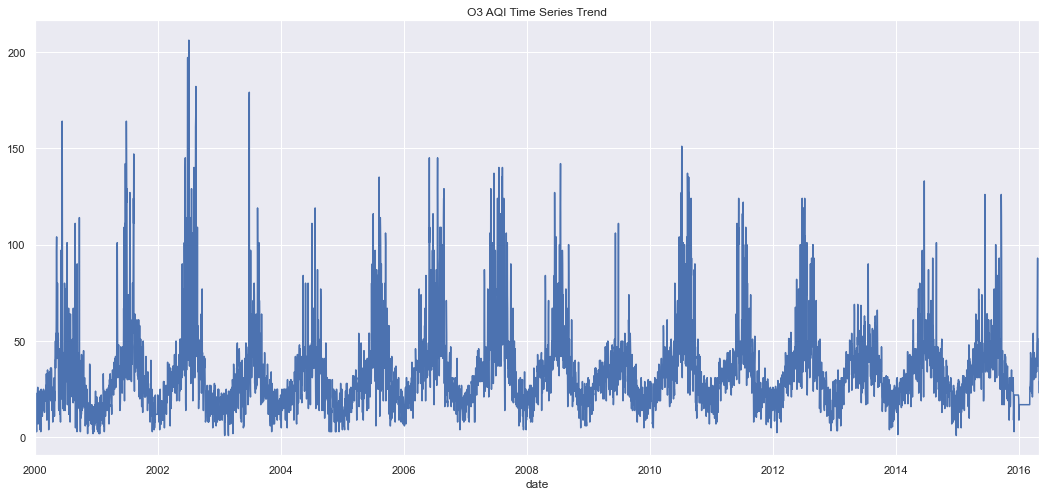

In [25]:
# visualize time series
ts.plot(figsize=(18,8))
plt.title(f'{col} Time Series Trend')

# Model 1 - ARIMA

Detailed explanation of ACF and PACF plot: https://online.stat.psu.edu/stat510/lesson/1/1.1


ACF and PACF are standard Time Series Plots. IT will help us to find AR and MA components in the Time Series Plot.

Detailed explanation of ACF and PACF plot is explained in the link.

Basically it is the correlation of present value with past value.

Generally there are only few signification lag value i.e. above the darker region which is like a confidence interval.

But in our case we ACF and PACF did not reveal any clear pattern as most of the lag value are above the darker region so we do not know what AR and MA components would be suitable for our Model

Text(0, 0.5, 'Correlation')

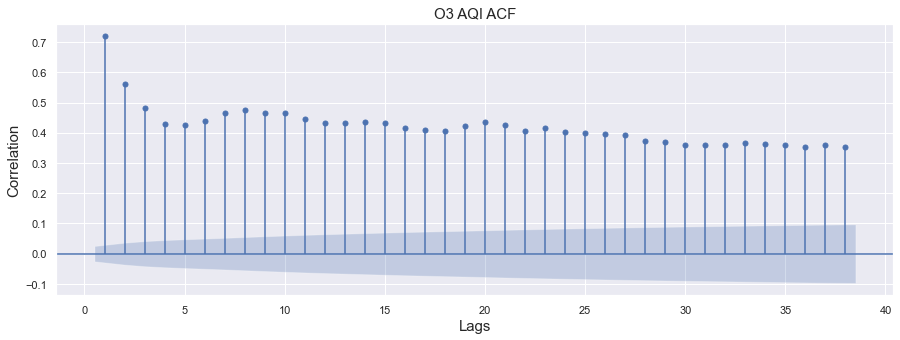

In [26]:
# plot Auto Corrleation
# about ACF https://online.stat.psu.edu/stat510/lesson/1/1.1

plt.rcParams['figure.figsize'] = (15,5)
sgt.plot_acf(ts, zero=False)
plt.title(f'{col} ACF',size=15)
plt.xlabel('Lags',size=15)
plt.ylabel('Correlation',size=15)

Text(0, 0.5, 'Correlation')

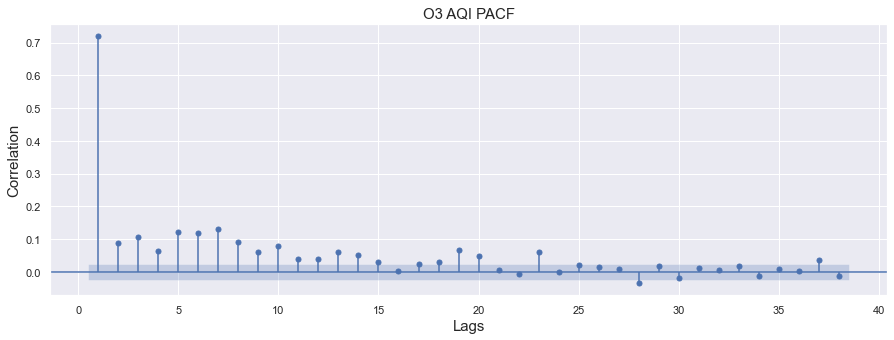

In [27]:
# plot Partial Autocorrrelation
plt.rcParams['figure.figsize'] = (15,5)
sgt.plot_pacf(ts, zero=False)
plt.title(f'{col} PACF',size=15)
plt.xlabel('Lags',size=15)
plt.ylabel('Correlation',size=15)

AR and MA compnents with seasonal effects are difficult to guess by looking at the ACF , PACF and Trend Plot. We will use Auto ARIMA Model which we will fit various model with different parameters and will find out the best model for this time series

To evaluate how good our model we compare it with the Test dataset. this is the standrad parctice in Machine Learning Model where have Train dataset on which we train the model and then there is a test data on model accuracy is tested.

For this time series we are using last 7 days value as test data and rest of the data is training dataset.

There is no reason for selecting 7 days, we can select any number of days but we have to keep in the mind that as the number of days are increaed the forecasting error keeps on increasing so need to select accordingly

we trained our model, then predict value for next 7 days and compare it with test dataset

In [28]:
# split the data into train and test data
# train data to train the model 
# test data to check the performance of the model on unseen data
# we will use last 7 days for testing 
forcast_period = 7
train = ts[:-7]
test = ts[-7:]

In [29]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

Train shape (5958,)
Test shape (7,)


Checking last three value in Train dataset and first three value in Test dataset so to ensure Test data starts from the next date where Train date ends

In [30]:
# check last 3 rows of the train data
train.tail(3)

date
2016-04-21    45.0
2016-04-22    39.0
2016-04-23    37.0
Freq: D, Name: O3 AQI, dtype: float64

In [31]:
# check first 3 rows of the train data
test.head(3)

date
2016-04-24    46.0
2016-04-25    48.0
2016-04-26    51.0
Freq: D, Name: O3 AQI, dtype: float64

In ARIMA model we would need specify the differencing Term i.e "I" component. This ADF Augmented Dickey Fuller Test is the standard way for checking what should be the value of "I". In our case it is zero

In [32]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(train, test='adf')  # -> 0
n_adf

0

In SARIMA model we would need specify the seasonal differencing Term component. This nsdiffs is way for checking what should be the value of seasonal differencing. In our case it is zero

In [33]:
# estimate number of seasonal differences using a Canova-Hansen test
# commonly requires knowledge of dataset
D = nsdiffs(train, m=2,  max_D=12,)  
D

0

There is no standard way for finding out what parameters to choose and it is basically a Trail and error method.

Auto Arima needs starting range and it automatically figure what should be the best parameter.

For P = 1 to P=5 it will fit all the model and see which models minimizes AIC criterion and select that value.

We dont know what is the best ARIMA model hence we are using Auto Arima which would fit model for the all the possible combination and find out what is the best ARIMA Model for our dataset.

In our CASE the best model is ARIMA(1,0,1)(1,0,2)[12] intercept

which has non seasonal arima compoents AR= 1 and MA=1 and season components of AR=1 and MA=1

In [34]:
# fit auto arima model
# read about params here https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
model = pm.auto_arima( train,        
                       start_p=1,    
                       start_q=1,    
                       max_p=5,   
                       max_q=5,     
                       m=12,        
                       seasonal=True, 
                       d=0,          
                       D=0, 
                       trace=True,
                       error_action='ignore', 
                       suppress_warnings=False, 
                       stepwise=True,
                       n_jobs = 1)

Performing stepwise search to minimize aic


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=48899.236, Time=12.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=53343.561, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=48970.297, Time=3.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=50217.559, Time=3.36 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=60837.365, Time=0.06 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=48916.015, Time=4.74 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=48915.664, Time=4.63 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=48893.362, Time=27.43 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=48903.517, Time=17.05 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=48900.467, Time=31.15 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=48893.022, Time=28.35 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=48905.862, Time=11.07 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=49718.886, Time=26.93 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=48925.244, Time=22.79 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=48907.622, Time=34.35 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=36.98 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=51534.960, Time=30.69 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=49315.101, Time=36.79 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=48903.002, Time=30.24 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=40.58 sec
 ARIMA(1,0,1)(1,0,2)[12]             : AIC=inf, Time=23.30 sec

Best model:  ARIMA(1,0,1)(1,0,2)[12] intercept
Total fit time: 426.970 seconds
